2020-03-29 18:46:21,406 - __main__ - INFO - DF:                                                 path     score  \
0  C:\Kaggle Downloads\deepfake-detection-challen...  0.983320   
1  C:\Kaggle Downloads\deepfake-detection-challen...  1.000000   
2  C:\Kaggle Downloads\deepfake-detection-challen...  0.983873   
3  C:\Kaggle Downloads\deepfake-detection-challen...  1.000000   
4  C:\Kaggle Downloads\deepfake-detection-challen...  0.972640   

                                       original_path  \
0  D:\Kaggle Downloads\deepfake-detection-challen...   
1  E:\Kaggle Downloads\deepfake-detection-challen...   
2  D:\Kaggle Downloads\deepfake-detection-challen...   
3  E:\Kaggle Downloads\deepfake-detection-challen...   
4  D:\Kaggle Downloads\deepfake-detection-challen...   

                     filename video_name_stem gross_label  score_1places  \
0  lthjbibrbq_293_98332.0.png      lthjbibrbq        fake            1.0   
1      gomwfvijiv_220_1.0.png      gomwfvijiv        real         

epoch,train_loss,valid_loss,cross_entropy,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Learner(data=ImageDataBunch;

Train: LabelList (231844 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
1,1,1,1,1
Path: C:\Kaggle Downloads\deepfake-detection-challenge\output\merged\images;

Valid: LabelList (39454 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
1,1,1,1,1
Path: C:\Kaggle Downloads\deepfake-detection-challenge\output\merged\images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

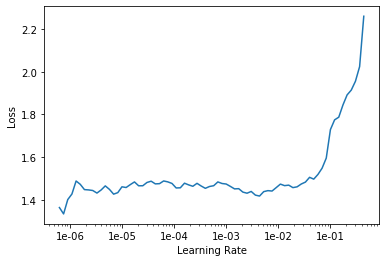

In [7]:
from pathlib import Path
from fastai.callbacks import SaveModelCallback
from fastai.vision import ImageList, cnn_learner, models, error_rate, accuracy, ShowGraph
from torch.nn.functional import cross_entropy
import config

import pandas as pd
from services import file_service

logger = config.create_logger(__name__)

image_path = Path('C:\\Kaggle Downloads\\deepfake-detection-challenge\\output\\merged\\images')
path = Path('C:\\Kaggle Downloads\\deepfake-detection-challenge\\output\\decorate_df\\dataframes\\df.pkl')
df = pd.read_pickle(path)

df = df.sample(frac=1).reset_index(drop=True)

df['real_or_fake_digit'] = df['gross_label'].apply(lambda x: 1 if x == 'fake' else 0)

num_rows = df.shape[0]

df_uncut = df

df = df.iloc[:num_rows//4, :]

logger.info(f'DF: {df.head()}')

df_val = df[df['test_train_split'] == 'validation']
df_train = df[df['test_train_split'] == 'train']


def balance_df(df):
    df_f = df[df['gross_label'] == 'fake']
    df_r = df[df['gross_label'] == 'real']

    num_real = df_r.shape[0]

    df_f = df_f.iloc[:num_real, :]
    return pd.concat([df_f, df_r])

df_train = balance_df(df_train)
df_val = balance_df(df_val)

df_test = df[df['test_train_split'] == 'test']

logger.info(f'df_val Index: {type(df_val.index)}')

val_path = Path(df_val.iloc[0, df_val.columns.get_loc('path')])
logger.info(f'Path: {val_path.parent}')

data = (ImageList.from_df(df, image_path, cols='filename')
  .split_by_idxs(train_idx=df_train.index, valid_idx=df_val.index)
  .label_from_df(cols='real_or_fake_digit')
  .databunch(bs=32))

model = models.resnet18

learn = cnn_learner(data, model, metrics=[cross_entropy, accuracy])
learn.model.cuda() 

learn.save('before-learner')
learn.lr_find()
learn.recorder.plot()
learn.load('before-learner')
# 3e-06,4e-06


epoch,train_loss,valid_loss,cross_entropy,accuracy,time
0,0.680667,0.678107,0.678107,0.571400,37:11
1,0.671376,0.664479,0.664478,0.595250,33:20
2,0.652114,0.649928,0.649928,0.616515,33:24
3,0.651627,0.641719,0.641719,0.623511,33:14
4,0.620730,0.624270,0.624270,0.651087,33:19
5,0.618491,0.613573,0.613573,0.657272,33:27
6,0.608981,0.603756,0.603756,0.668551,33:11
7,0.597111,0.605635,0.605635,0.666498,33:23
8,0.602006,0.591388,0.591388,0.677549,33:19
9,0.581700,0.619742,0.619742,0.665788,33:11


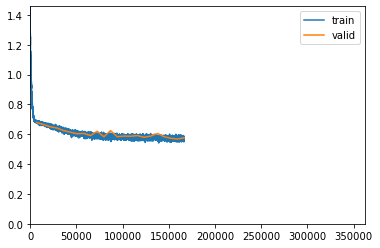

KeyboardInterrupt: 

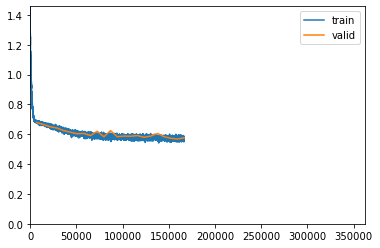

In [8]:
from fastai.callbacks import EarlyStoppingCallback
from fastai.vision import partial

file_path = file_service.get_unique_persist_filename(config.OUTPUT_MODEL_PAR_PATH, base_output_stem=f'cnn_resnet34_', extension='pkl', use_date=True)

learn.fit_one_cycle(50, slice(1e-03,3e-03), callbacks=[ShowGraph(learn), SaveModelCallback(learn, every='epoch',  
                  monitor='cross_entropy', name=file_path)])

In [9]:
pickle_par_path = Path(config.OUTPUT_MODEL_PAR_PATH, 'data')
pickle_par_path.mkdir(exist_ok=True)

df.to_pickle(Path(pickle_par_path, 'df'))
df_train.to_pickle(Path(pickle_par_path, 'df_train'))
df_val.to_pickle(Path(pickle_par_path, 'df_val'))
df_test.to_pickle(Path(pickle_par_path, 'df_test'))


In [11]:
data.path = pickle_par_path

data.save()

learn_par_path = Path(config.OUTPUT_MODEL_PAR_PATH, 'learners')
learn_par_path.mkdir(exist_ok=True)
learn_path = Path(learn_par_path, 'cnn_learner.pkl')

learn.export(learn_path)

epoch,train_loss,valid_loss,cross_entropy,accuracy,time
0,0.556485,0.566800,0.566800,0.704390,27:16
1,0.551780,0.556969,0.556969,0.713008,26:46
2,0.558862,0.563114,0.563113,0.703630,26:47
3,0.563919,0.559598,0.559598,0.710067,26:32
4,0.558623,0.583793,0.583793,0.691286,26:44
5,0.553031,0.586411,0.586411,0.694175,26:36
6,0.565860,0.569053,0.569054,0.700512,26:38
7,0.561030,0.568358,0.568358,0.706950,26:32
8,0.551098,0.594631,0.594631,0.687636,26:38
9,0.541232,0.552316,0.552316,0.713616,26:46


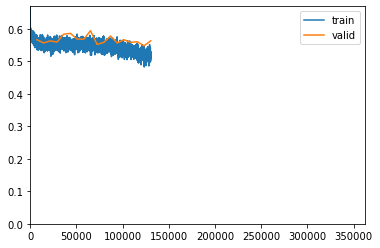

RuntimeError: Caught RuntimeError in DataLoader worker process 5.
Original Traceback (most recent call last):
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\torch\utils\data\_utils\worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\torch\utils\data\_utils\fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\fastai\torch_core.py", line 127, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\torch\utils\data\_utils\collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\torch\utils\data\_utils\collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\torch\utils\data\_utils\collate.py", line 53, in default_collate
    storage = elem.storage()._new_shared(numel)
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\torch\storage.py", line 128, in _new_shared
    return cls._new_using_filename(size)
RuntimeError: Couldn't open shared file mapping: <torch_18628_3606851850>, error code: <1455>


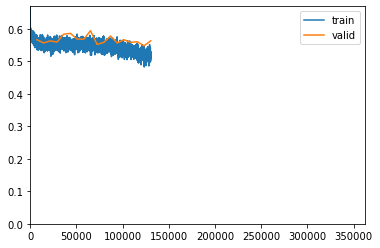

In [12]:
learn.unfreeze()
learn.fit_one_cycle(50, slice(1e-03,3e-03), callbacks=[ShowGraph(learn), SaveModelCallback(learn, every='epoch',  
                  monitor='cross_entropy', name=file_path)])